In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import gensim
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.decomposition import PCA

In [2]:
nlp_model = gensim.models.KeyedVectors.load_word2vec_format('/Users/joshuadarcy/Desktop/GoogleNews-vectors-negative300.bin', binary = True)

### Create Food Preferences

In [54]:
#User 1 Liked items
u1l = ['spinach','bread','mushrooms','walnut', 'chicken', 'pecans', 'cheeseburger', 'steak']

#User 2 Liked items
u2l = ['fries','ranch','steak','milk', 'turkey', 'milkshake','fried']

#Make them opposite
u2d = u1l
u1d = u2l

#Get word vectors for user1 preferences, create labels
u1l = [nlp_model.get_vector(pref) for pref in u1l]
u1l_labels = np.ones(len(u1l))

#Same for user2
u2l = [nlp_model.get_vector(pref) for pref in u2l]
u2l_labels = np.ones(len(u2l))

#Make them opposite
u1d = u2l
u2d = u1l

In [55]:
#Construct User 1 Training

user1_training_data = np.concatenate((u1l,u1d))
user1_training_data = user1_training_data.reshape(-1,1,300)
user1_training_labels = np.concatenate((np.zeros(len(u1l)),np.ones(len(u1d))))

In [56]:
#Construct User 2 Training

user2_training_data = np.concatenate((u2l,u2d))
user2_training_data = user2_training_data.reshape(-1,1,300)
user2_training_labels = np.concatenate((np.zeros(len(u2l)),np.ones(len(u2d))))

### Train & Compare Food Preference Model

In [58]:
#Build and Run for both

u1_model = construct_run(user1_training_data, user1_training_labels)
u2_model = construct_run(user2_training_data, user2_training_labels)

In [60]:
compare_models(u1_model,u2_model,'steak')

User 1 estimated probability of enjoying steak is 50%
User 2 estimated robability of enjoying steak is 49%


### Define Functions

In [356]:
def construct_run(training_data,labels):
    #general model, architecture can be further refined later for opimization
    model = keras.Sequential([
        keras.layers.Dense(128, input_shape = (1,300)),
        keras.layers.Dense(128, activation=tf.nn.relu),
        keras.layers.Dense(2, activation=tf.nn.softmax)
    ]);
    #compile using sparse_cat & adam
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    #train model using 500 epochs, can be changed later. Verbose = 0 for demo.
    model.fit(training_data, labels, epochs=500, verbose = 0)
    return model

def compare_models(model1,model2,keyword): 
    prediction1 = model1.predict(nlp_model.get_vector(keyword).reshape(1,1,300))[0][0][0]
    rounded1 = int(100* round(prediction1, 2))
    prediction2 = model2.predict(nlp_model.get_vector(keyword).reshape(1,1,300))[0][0][0]
    rounded2 = int(100* round(prediction2, 2))
    print("User 1 estimated probability of enjoying {0} is {1}%\nUser 2 estimated robability of enjoying {0} is {2}%".format(keyword,rounded1,rounded2))
    
def reshape_scale_data(raw_input,samples): 
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(raw_input)
    reshaped = scaled_data.reshape(samples,5)
    return reshaped, scaler

def create_user(preference_mean, preference_sd, distance,step_count,time_of_day,samples): 
    #create dataset with given standard deviations
    params = [(preference_mean,0.2), (preference_sd,.01), (distance, 50), (step_count,400), (time_of_day,100)]
    raw_data = np.zeros([samples,len(params)])
    labels = np.ones(samples)
    for count,param in enumerate(params): 
        raw_data[:,count] = np.random.normal(param[0], param[1], samples)
        counter2 = 0
        #if ALL paramters within 1 standard deviation
        #respond with 1 "yes", else respond with 0 "no"

        for sample in raw_data[:,count]:
            random = np.random.random(1)
            if sample > (param[0] + param[1]):
                labels[counter2] = 0
            if sample < (param[0] - param[1]):
                labels[counter2] = 0
            if random > .9: 
                labels[counter2] = 0
            counter2 += 1
            
    data, scaler_un = reshape_scale_data(raw_data,samples)
    
    return data,labels,scaler_un

def naive_model():
    state_model = keras.Sequential([
        keras.layers.Dense(28, input_shape = (5,)),
        keras.layers.Dense(28, activation=tf.nn.relu),
        keras.layers.Dense(2, activation=tf.nn.softmax)
    ]);
    state_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return state_model

def create_scenario_vector(menu_item, fp_model, scaler_0, distance, steps, time): 
    fp = []
    for ingredient in menu_item: 
        prediction = fp_model.predict(nlp_model.get_vector(ingredient).reshape(1,1,300))[0][0][0]
        fp.append(prediction)
    
    fp_avg = sum(fp) / len(fp)
    fp_std = .01
    input_array = [fp_avg, fp_std, distance, steps, time]
    print(input_array)
    reshaped = np.array(input_array).reshape(-1,5)
    scaled = scaler_0.transform(reshaped)
    return scaled

def test_input(input_vector, state_model): 
    estimate = state_model.predict(input_vec)[0][1]
    rounded = int(100 * round(estimate,2))
    print("Estimated chance of user compliance is {}%".format(rounded))

def create_test(preference_mean, preference_sd, distance,step_count,time_of_day,samples): 

    #create dataset with given standard deviations
    params = [(preference_mean,0.5), (preference_sd,.05), (distance, 400), (step_count,400), (time_of_day,300)]
    raw_data = np.zeros([samples,len(params)])

    for count,param in enumerate(params): 
        raw_data[:,count] = np.random.normal(param[0], param[1], samples)
    return raw_data

def return_to_original(scaler,scaled,index_array):
    ret = []
    for index in index_array: 
        ret.append(scaler.inverse_transform(scaled[index]))
    return ret

### Create State Preferences

In [390]:
u1data,u1labels,u1scaler = create_user(1,.01,150,1200,1300,2000)
u2data,u2labels,u2scaler = create_user(1,.01,100,800,1600,2000)

### Train State Model

In [391]:
u1_state_model = naive_model()
u1_state_model.fit(u1data, u1labels, epochs=200, verbose = 1)

u2_state_model = naive_model()
u2_state_model.fit(u2data, u2labels, epochs=200, verbose = 1)

Epoch 1/200
2000/2000 [==============================] - 0s 134us/sample - loss: 0.6032 - acc: 0.6585
Epoch 2/200
2000/2000 [==============================] - 0s 51us/sample - loss: 0.2920 - acc: 0.9105
Epoch 3/200
2000/2000 [==============================] - 0s 56us/sample - loss: 0.2516 - acc: 0.9105
Epoch 4/200
2000/2000 [==============================] - 0s 42us/sample - loss: 0.2418 - acc: 0.9105
Epoch 5/200
2000/2000 [==============================] - 0s 46us/sample - loss: 0.2371 - acc: 0.9105
Epoch 6/200
2000/2000 [==============================] - 0s 46us/sample - loss: 0.2329 - acc: 0.9105
Epoch 7/200
2000/2000 [==============================] - 0s 44us/sample - loss: 0.2289 - acc: 0.9105
Epoch 8/200
2000/2000 [==============================] - 0s 42us/sample - loss: 0.2255 - acc: 0.9105
Epoch 9/200
2000/2000 [==============================] - 0s 45us/sample - loss: 0.2223 - acc: 0.9105
Epoch 10/200
2000/2000 [==============================] - 0s 48us/sample - loss: 0.2186 - 

2000/2000 [==============================] - 0s 44us/sample - loss: 0.1418 - acc: 0.9305
Epoch 82/200
2000/2000 [==============================] - 0s 38us/sample - loss: 0.1418 - acc: 0.9285
Epoch 83/200
2000/2000 [==============================] - 0s 39us/sample - loss: 0.1414 - acc: 0.9305
Epoch 84/200
2000/2000 [==============================] - 0s 41us/sample - loss: 0.1430 - acc: 0.9300
Epoch 85/200
2000/2000 [==============================] - 0s 40us/sample - loss: 0.1415 - acc: 0.9290
Epoch 86/200
2000/2000 [==============================] - 0s 37us/sample - loss: 0.1414 - acc: 0.9290
Epoch 87/200
2000/2000 [==============================] - 0s 40us/sample - loss: 0.1417 - acc: 0.9300
Epoch 88/200
2000/2000 [==============================] - 0s 41us/sample - loss: 0.1440 - acc: 0.9315
Epoch 89/200
2000/2000 [==============================] - 0s 41us/sample - loss: 0.1420 - acc: 0.9315
Epoch 90/200
2000/2000 [==============================] - 0s 38us/sample - loss: 0.1420 - acc: 

2000/2000 [==============================] - 0s 40us/sample - loss: 0.1391 - acc: 0.9310
Epoch 161/200
2000/2000 [==============================] - 0s 46us/sample - loss: 0.1394 - acc: 0.9305
Epoch 162/200
2000/2000 [==============================] - 0s 43us/sample - loss: 0.1391 - acc: 0.9305
Epoch 163/200
2000/2000 [==============================] - 0s 42us/sample - loss: 0.1402 - acc: 0.9320
Epoch 164/200
2000/2000 [==============================] - 0s 41us/sample - loss: 0.1387 - acc: 0.9305
Epoch 165/200
2000/2000 [==============================] - 0s 43us/sample - loss: 0.1398 - acc: 0.9300
Epoch 166/200
2000/2000 [==============================] - 0s 42us/sample - loss: 0.1415 - acc: 0.9315
Epoch 167/200
2000/2000 [==============================] - 0s 40us/sample - loss: 0.1395 - acc: 0.9310
Epoch 168/200
2000/2000 [==============================] - 0s 39us/sample - loss: 0.1401 - acc: 0.9295
Epoch 169/200
2000/2000 [==============================] - 0s 44us/sample - loss: 0.139

2000/2000 [==============================] - 0s 47us/sample - loss: 0.1394 - acc: 0.9295
Epoch 41/200
2000/2000 [==============================] - 0s 44us/sample - loss: 0.1387 - acc: 0.9295
Epoch 42/200
2000/2000 [==============================] - 0s 45us/sample - loss: 0.1386 - acc: 0.9320
Epoch 43/200
2000/2000 [==============================] - 0s 41us/sample - loss: 0.1384 - acc: 0.9305
Epoch 44/200
2000/2000 [==============================] - 0s 46us/sample - loss: 0.1378 - acc: 0.9335
Epoch 45/200
2000/2000 [==============================] - 0s 40us/sample - loss: 0.1378 - acc: 0.9280
Epoch 46/200
2000/2000 [==============================] - 0s 45us/sample - loss: 0.1366 - acc: 0.9330
Epoch 47/200
2000/2000 [==============================] - 0s 40us/sample - loss: 0.1364 - acc: 0.9310
Epoch 48/200
2000/2000 [==============================] - 0s 47us/sample - loss: 0.1363 - acc: 0.9315
Epoch 49/200
2000/2000 [==============================] - 0s 41us/sample - loss: 0.1365 - acc: 

2000/2000 [==============================] - 0s 44us/sample - loss: 0.1297 - acc: 0.9375
Epoch 121/200
2000/2000 [==============================] - 0s 40us/sample - loss: 0.1304 - acc: 0.9355
Epoch 122/200
2000/2000 [==============================] - 0s 44us/sample - loss: 0.1301 - acc: 0.9345
Epoch 123/200
2000/2000 [==============================] - 0s 41us/sample - loss: 0.1303 - acc: 0.9345
Epoch 124/200
2000/2000 [==============================] - 0s 42us/sample - loss: 0.1303 - acc: 0.9385
Epoch 125/200
2000/2000 [==============================] - 0s 43us/sample - loss: 0.1305 - acc: 0.9390
Epoch 126/200
2000/2000 [==============================] - 0s 42us/sample - loss: 0.1304 - acc: 0.9370
Epoch 127/200
2000/2000 [==============================] - 0s 41us/sample - loss: 0.1302 - acc: 0.9360
Epoch 128/200
2000/2000 [==============================] - 0s 41us/sample - loss: 0.1307 - acc: 0.9350
Epoch 129/200
2000/2000 [==============================] - 0s 39us/sample - loss: 0.130

Epoch 199/200
2000/2000 [==============================] - 0s 42us/sample - loss: 0.1304 - acc: 0.9325
Epoch 200/200
2000/2000 [==============================] - 0s 43us/sample - loss: 0.1289 - acc: 0.9375


### Test Individual Scenarios

In [392]:
food = ['kale','bread']
input_vec = create_scenario_vector(food,u1_model,u1scaler,150,1200,1300)
test_input(input_vec, u1_state_model)

[0.9999706745147705, 0.01, 150, 1200, 1300]
Estimated chance of user compliance is 98%


In [393]:
food = ['fries','turkey']
input_vec = create_scenario_vector(food,u2_model,u2scaler, 100,800,1600)
test_input(input_vec, u2_state_model)

[0.9999551177024841, 0.01, 100, 800, 1600]
Estimated chance of user compliance is 98%


### Arbitrarily Create 1 Million Scenarios, Choose Top 20 for Each User

In [394]:
test_data = create_test(1,.01, 125, 1000, 1450, 1000000)
scaled_u1 = u1scaler.transform(test_data)
scaled_u2 = u2scaler.transform(test_data)

In [395]:
array_1 = np.array(u1_state_model.predict(scaled_u1)).T[1]
array_2 = np.array(u2_state_model.predict(scaled_u2)).T[1]

In [396]:
index1 = np.argsort(-array_1)[0:20]
index2 = np.argsort(-array_2)[0:20]

In [397]:
best_20_u1 = return_to_original(u1scaler,scaled_u1,index1)
best_20_u2 = return_to_original(u2scaler,scaled_u2,index2)

In [398]:
x = np.concatenate((best_20_u1, best_20_u2))

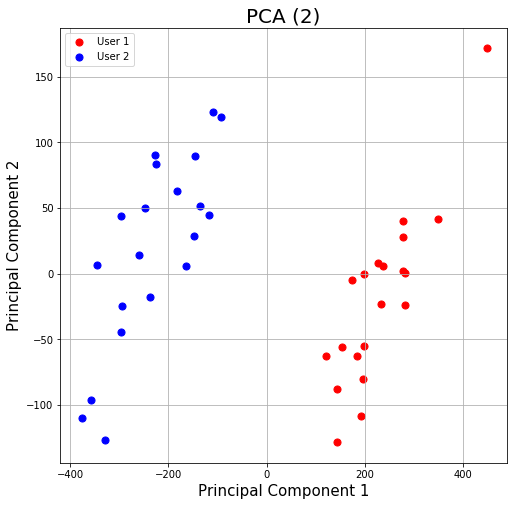

In [399]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
label_array = np.concatenate((np.ones(20),2*np.ones(20)))
labels = pd.DataFrame(label_array,columns = ['Label'])
finalDf = pd.concat([principalDf, labels], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA (2)', fontsize = 20)
targets = [1.0, 2.0]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)

stringed = ['User {}'.format(target)[0:6] for target in targets]
ax.legend(stringed)
ax.grid()

In [400]:
nlp_model.similarity('food','Alaska')

0.041435394

### Algo for Christina

In [432]:
test_word = ['steak','Alaska','basketball','pear','tabletop', 'fingernail', 'apple', 'thumb', 'snow', 'crab']

for word in test_word: 
    if nlp_model.similarity('edible',word) > .1 and nlp_model.similarity('food',word) > .15:
        print(word)

steak
pear
apple
crab
